# Importação das bibliotecas

In [1]:
import pandas as pd
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from scipy.stats import shapiro, jarque_bera
import seaborn as sns
from sklearn.svm import SVR

# Leitura e Tratamento dos Dados
### Lendo os arquivos csvs e iniciando a exploração

In [2]:
diretorio_atual = os.getcwd()
path_dados = os.path.join(diretorio_atual, 'dados')
lista_arquivos = os.listdir(path_dados)

In [3]:
list_df = []
for arquivo in lista_arquivos:
    if arquivo.endswith('.csv'):
        arq_df = pd.read_csv(os.path.join(path_dados, arquivo), sep=";", encoding='latin1', low_memory=False)
        arq_df = arq_df[arq_df['Estado - Sigla'] == 'PB']
        list_df.append(arq_df)
        
df = pd.concat(list_df)

In [4]:
print(df.shape)
df.head()

(41226, 17)


,ï»¿Regiao - Sigla,Estado - Sigla,Municipio,Revenda,CNPJ da Revenda,Nome da Rua,Numero Rua,Complemento,Bairro,Cep,Produto,Data da Coleta,Valor de Venda,Valor de Compra,Unidade de Medida,Bandeira,Regiao - Sigla
1505,NE,PB,BAYEUX,MOTOGAS INDUSTRIA DE COMPRESSAO E COMERCIO DE ...,01.420.327/0001-85,LOC BR 230 KM 31,S/N,NaN,ESTRADA,58309-602,ETANOL,02/01/2023,"3,65",NaN,R$ / litro,BRANCA,NaN
1506,NE,PB,BAYEUX,MOTOGAS INDUSTRIA DE COMPRESSAO E COMERCIO DE ...,01.420.327/0001-85,LOC BR 230 KM 31,S/N,NaN,ESTRADA,58309-602,DIESEL S10,02/01/2023,"6,29",NaN,R$ / litro,BRANCA,NaN
1507,NE,PB,BAYEUX,MOTOGAS INDUSTRIA DE COMPRESSAO E COMERCIO DE ...,01.420.327/0001-85,LOC BR 230 KM 31,S/N,NaN,ESTRADA,58309-602,DIESEL,02/01/2023,"6,19",NaN,R$ / litro,BRANCA,NaN
1508,NE,PB,BAYEUX,MOTOGAS INDUSTRIA DE COMPRESSAO E COMERCIO DE ...,01.420.327/0001-85,LOC BR 230 KM 31,S/N,NaN,ESTRADA,58309-602,GASOLINA,02/01/2023,"4,79",NaN,R$ / litro,BRANCA,NaN
1509,NE,PB,BAYEUX,MOTOGAS INDUSTRIA DE COMPRESSAO E COMERCIO DE ...,01.420.327/0001-85,LOC BR 230 KM 31,S/N,NaN,ESTRADA,58309-602,GNV,02/01/2023,"4,64",NaN,R$ / mÂ³,BRANCA,NaN


In [5]:
print(df["Municipio"].unique())
print(df["Produto"].unique())
print(df["Unidade de Medida"].unique())

['BAYEUX' 'CABEDELO' 'CAMPINA GRANDE' 'JOAO PESSOA' 'PATOS' 'SOUSA']
['ETANOL' 'DIESEL S10' 'DIESEL' 'GASOLINA' 'GNV' 'GASOLINA ADITIVADA']
['R$ / litro' 'R$ / mÂ³' 'R$ / m³']


In [6]:
# Transformando a coluna data da coleta em tipo date
df["Data da Coleta"] = pd.to_datetime(df['Data da Coleta'], format="%d/%m/%Y")
#df = df[df['Data da Coleta'] >= '2023-01-01']

In [7]:
# Transformando a coluna Valor de Venda em float
df["Valor de Venda"] = df['Valor de Venda'].str.replace(',', '.').astype(float)

In [8]:
# Resumindo para um valor por dia, fazendo a media do preco entre os postos de combustiveis
df = df.groupby(["Data da Coleta", "Produto"]).agg({'Valor de Venda': 'mean'}).reset_index()

### Verificando a frequencia das coletas dos preços

In [9]:
df_aux = df[df['Produto'] == 'GASOLINA']
# Ordenando o dataframe pela data da coleta
df_aux = df_aux.sort_values('Data da Coleta')

# Calcular a diferença entre as datas consecutivas
df_aux['diferenca'] = df_aux['Data da Coleta'].diff(1)

# printa a data e a diferença dos 10 primeiros registros com maior diferença
print(df_aux[['Data da Coleta', 'diferenca']].nlargest(10, 'diferenca'))

# agrupa por diferença e conta quantas vezes cada diferença aparece
print(df_aux['diferenca'].value_counts())

     Data da Coleta diferenca
540      2020-10-19   63 days
2594     2022-09-26   13 days
575      2020-11-09    7 days
2600     2022-10-03    7 days
2606     2022-10-10    7 days
2651     2022-11-07    7 days
322      2020-05-12    6 days
382      2020-06-09    6 days
607      2020-11-23    6 days
2582     2022-09-12    6 days
diferenca
1 days     478
4 days      92
5 days      63
3 days      33
2 days      25
6 days       7
7 days       4
63 days      1
13 days      1
Name: count, dtype: int64


In [10]:
# Garantir que a coluna "Data da Coleta" esteja no índice e ordenada
df.set_index("Data da Coleta", inplace=True)
df.sort_index(inplace=True)

### Para o estudo iremos utilizar apenas gasolina

df_gasolina:  (705, 1)


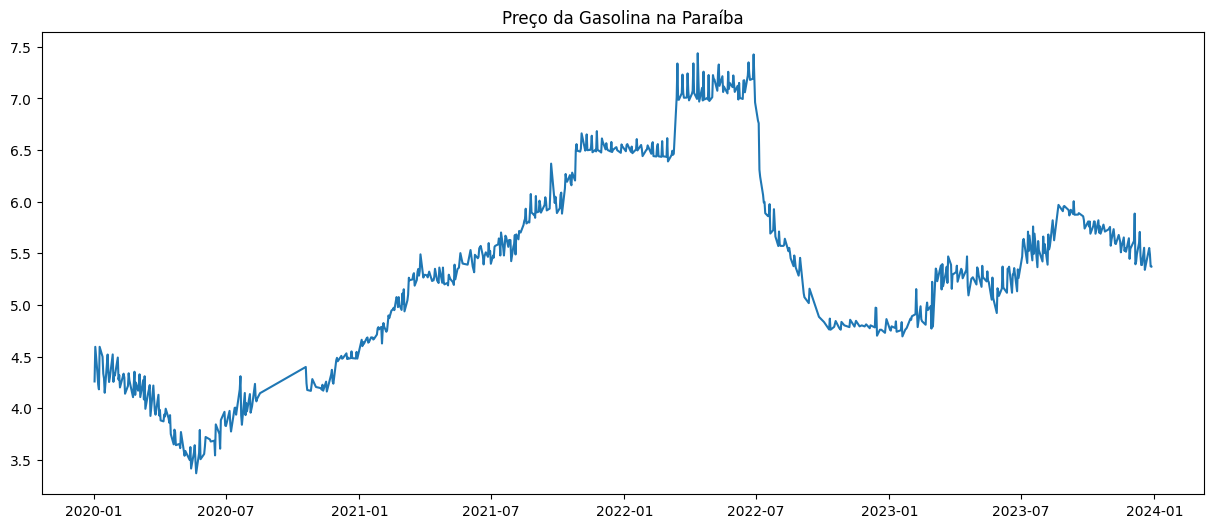

In [11]:
# Filtrar e selecionar colunas para GASOLINA
df_gasolina = df[df["Produto"] == "GASOLINA"][["Valor de Venda"]]
print("df_gasolina: ", df_gasolina.shape)

fig = plt.figure(figsize=(15, 6))
plt.plot(df_gasolina)
plt.title("Preço da Gasolina na Paraíba")
plt.show()

# Decomposição da serie

In [12]:
# Decomposição da série temporal
decomposicao_g = seasonal_decompose(df_gasolina, model="additive", period=365)
#decomposicao_g = seasonal_decompose(df_gasolina, model="multiplicative", period=365)

# Extrair os componentes
tendencia_g = decomposicao_g.trend
sazonalidade_g = decomposicao_g.seasonal
residuos_g = decomposicao_g.resid

# Criar um gráfico com subplots
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

# Plotar os gráficos
axs[0].plot(df_gasolina, label="Série Original")
axs[0].legend(loc="upper left")
axs[0].set_title('Série Original')

axs[1].plot(tendencia_g, label="Tendência", color='orange')
axs[1].legend(loc="upper left")
axs[1].set_title('Tendência')

axs[2].plot(sazonalidade_g, label="Sazonalidade", color='green')
axs[2].legend(loc="upper left")
axs[2].set_title('Sazonalidade')

axs[3].plot(residuos_g, label="Resíduos", color='red')
axs[3].legend(loc="upper left")
axs[3].set_title('Resíduos')

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()


ValueError: x must have 2 complete cycles requires 730 observations. x only has 705 observation(s)

In [ ]:
def check_stationarity(series):

    result = adfuller(series) 

    print('Estatística ADF: %f' % result[0])

    print('p-valor: %f' % result[1])
    if result[1]<0.05:
        print('A série temporal é estacionária')
    else: 
        print('A série temporal não é estacionária pois p-valor ≥ 0,05')

check_stationarity(df_gasolina["Valor de Venda"])

Estatística ADF: -1.128885
p-valor: 0.703417
A série temporal não é estacionária pois p-valor ≥ 0,05


### Normalidade do residuo

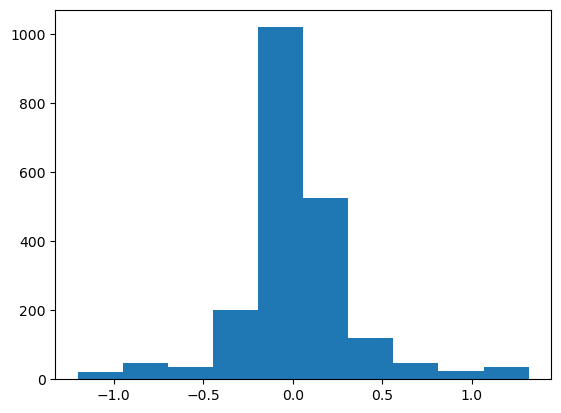

In [ ]:
plt.hist(residuos_g)
plt.show()

### Outliers

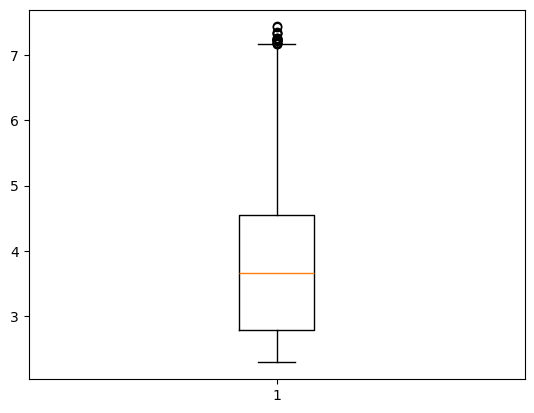

In [ ]:
plt.boxplot(df_gasolina)
plt.show()

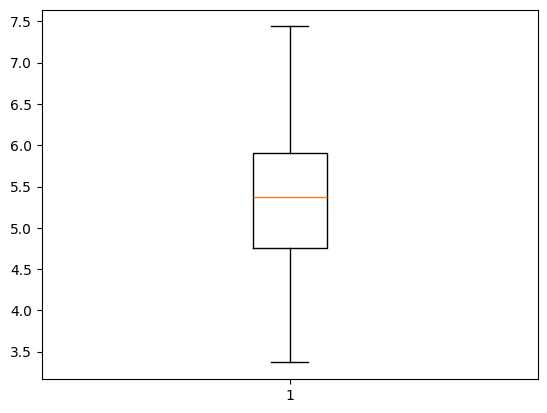

In [13]:
# Calculate the z-score for each value in the 'Valor de Venda' column
z_scores = (df_gasolina['Valor de Venda'] - df_gasolina['Valor de Venda'].mean()) / df_gasolina['Valor de Venda'].std()

# Define a threshold for outliers (e.g., z-score > 3 or z-score < -3)
threshold = 3

# Filter out the outliers based on the threshold
df_gasolina= df_gasolina[abs(z_scores) <= threshold]

plt.boxplot(df_gasolina)
plt.show()

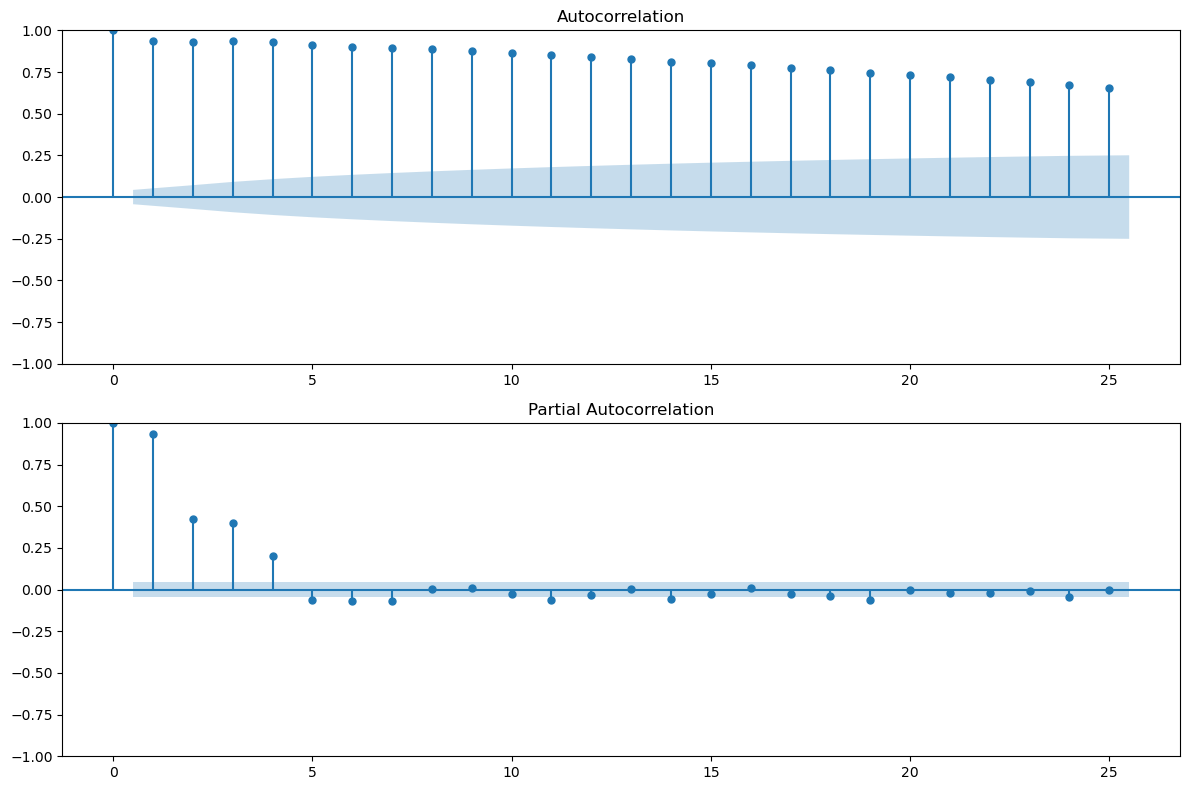

In [ ]:
def plot_acf_pacf_graphs(series):
    fig, ax = plt.subplots(2,1)
    fig.set_size_inches(12, 8)
    fig = sm.graphics.tsa.plot_acf(series, lags=25, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(series, lags=25, ax=ax[1])
    plt.tight_layout()
    plt.show()

plot_acf_pacf_graphs(residuos_g.dropna())

# Utilizando o modelo AutoArima

### Treinando o modelo

In [ ]:
# Definir o tamanho dos conjuntos
total_length = len(df_gasolina)
train_size = int(0.8 * total_length)
test_size = int(0.1 * total_length)

# Separar os dados
train = df_gasolina.iloc[:train_size]
test = df_gasolina.iloc[train_size:]

# Ajustar o modelo com o conjunto de treino
model_auto_arima = auto_arima(train["Valor de Venda"], seasonal=True, m=12)


### Realizando a previsão

c:\Users\ivoar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ivoar\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


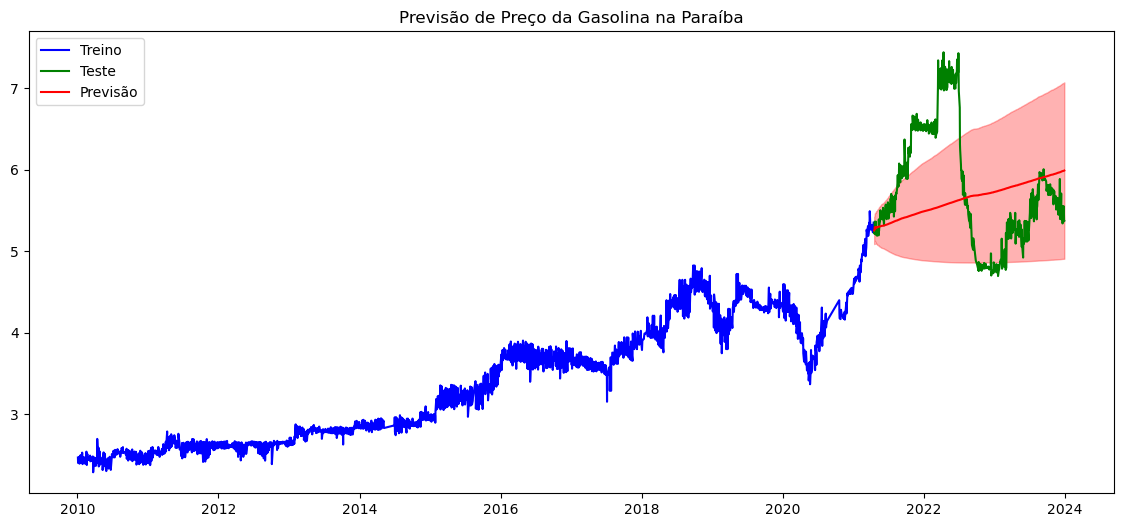

In [ ]:
# Previsão para o conjunto de teste
forecast, conf_int = model_auto_arima.predict(n_periods=len(test), return_conf_int=True)

results_df = test.copy()
results_df['Forecast'] = forecast.values
results_df['Lower CI'] = conf_int[:, 0]
results_df['Upper CI'] = conf_int[:, 1]


# Visualizar o resultado
plt.figure(figsize=(14, 6))
plt.plot(train, label='Treino', color='blue')
plt.plot(test, label='Teste', color='green')
plt.plot(results_df['Forecast'], label='Previsão', color='red')
plt.fill_between(results_df.index, results_df['Lower CI'], results_df['Upper CI'], color='red', alpha=0.3)
plt.legend(loc='upper left')
plt.title('Previsão de Preço da Gasolina na Paraíba')
plt.show()

### Avaliando o modelo

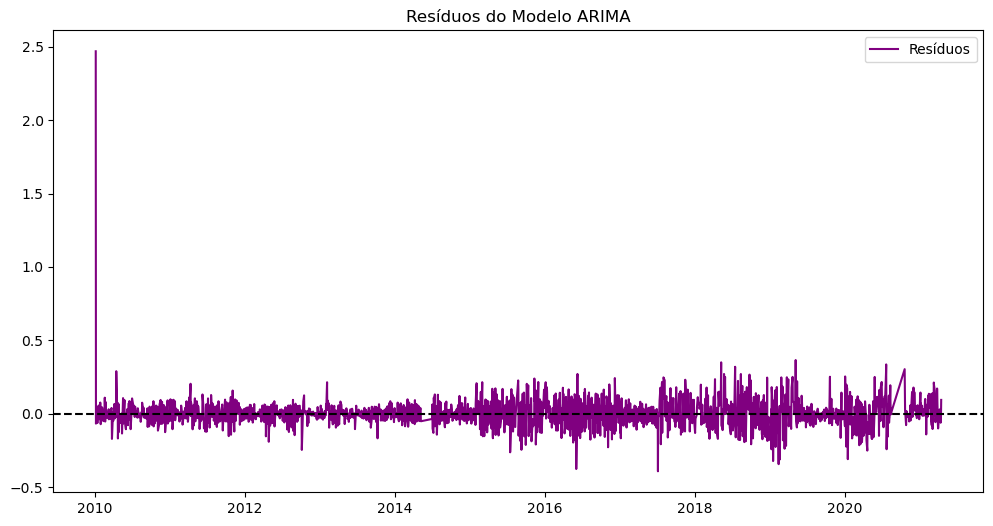

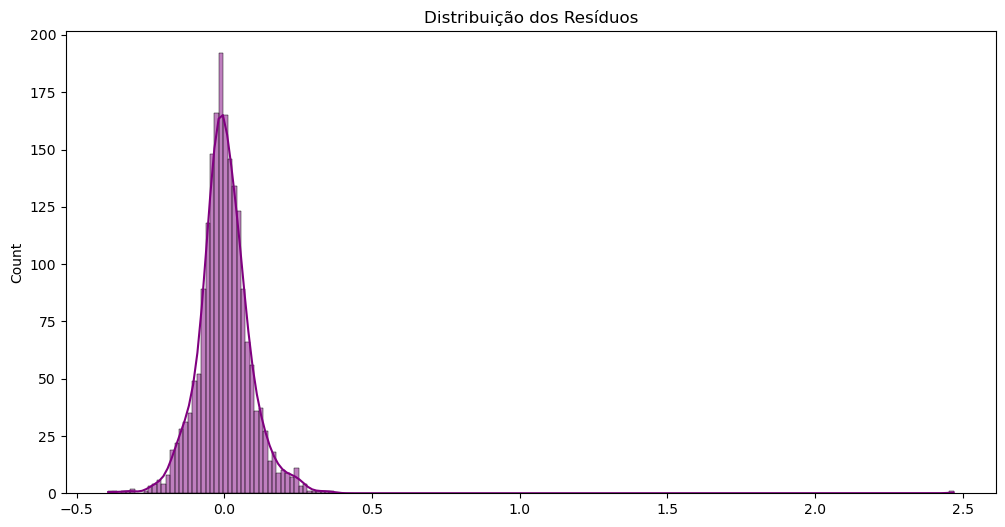

Shapiro-Wilk Test: W=0.7550, p-value=0.0000
Jarque-Bera Test: Statistic=2533070.5000, p-value=0.0000

Explicação dos resultados:
Shapiro-Wilk Test: A distribuição dos resíduos difere significativamente de uma distribuição normal.
Jarque-Bera Test: A distribuição dos resíduos difere significativamente de uma distribuição normal.


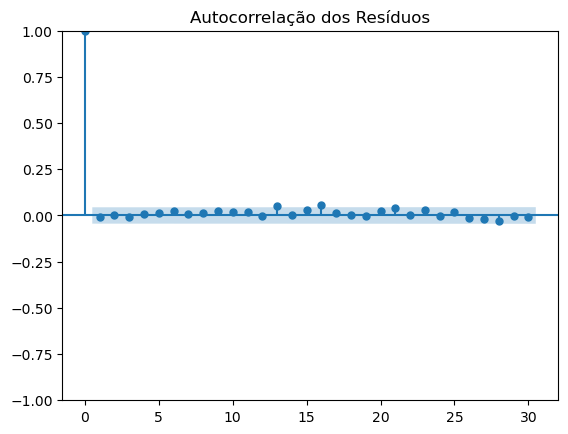

In [ ]:
# Obtenha os resíduos
residuals = model_auto_arima.resid()

# Exibindo os primeiros valores dos resíduos

# Plotar os resíduos
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Resíduos', color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.legend()
plt.title('Resíduos do Modelo ARIMA')
plt.show()

# Visualizar a distribuição dos resíduos
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Distribuição dos Resíduos')
plt.show()

# Teste de normalidade (Shapiro-Wilk)
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")

# Teste de normalidade (Jarque-Bera)
jarque_bera_test = jarque_bera(residuals)
print(f"Jarque-Bera Test: Statistic={jarque_bera_test.statistic:.4f}, p-value={jarque_bera_test.pvalue:.4f}")

# Explicação dos resultados
print("\nExplicação dos resultados:")
if shapiro_test.pvalue > 0.05:
    print("Shapiro-Wilk Test: A distribuição dos resíduos não difere significativamente de uma distribuição normal.")
else:
    print("Shapiro-Wilk Test: A distribuição dos resíduos difere significativamente de uma distribuição normal.")
    
if jarque_bera_test.pvalue > 0.05:
    print("Jarque-Bera Test: A distribuição dos resíduos não difere significativamente de uma distribuição normal.")
else:
    print("Jarque-Bera Test: A distribuição dos resíduos difere significativamente de uma distribuição normal.")

# Plotar ACF dos resíduos
plot_acf(residuals, lags=30)
plt.title('Autocorrelação dos Resíduos')
plt.show()


# Abordando com SVR (Support Vector Regression)

### treinando o modelo

In [ ]:
# Definir o tamanho dos conjuntos
total_length = len(df_gasolina)
train_size = int(0.8 * total_length)
test_size = int(0.1 * total_length)

# Separar os dados
train = df_gasolina.iloc[:train_size]
test = df_gasolina.iloc[train_size:]

# Ajustar o modelo com o conjunto de treino
model_svr = SVR(kernel='rbf')
model_svr.fit(train.index.to_numpy().reshape(-1, 1), train["Valor de Venda"])

SVR()

### Realizando a previsão

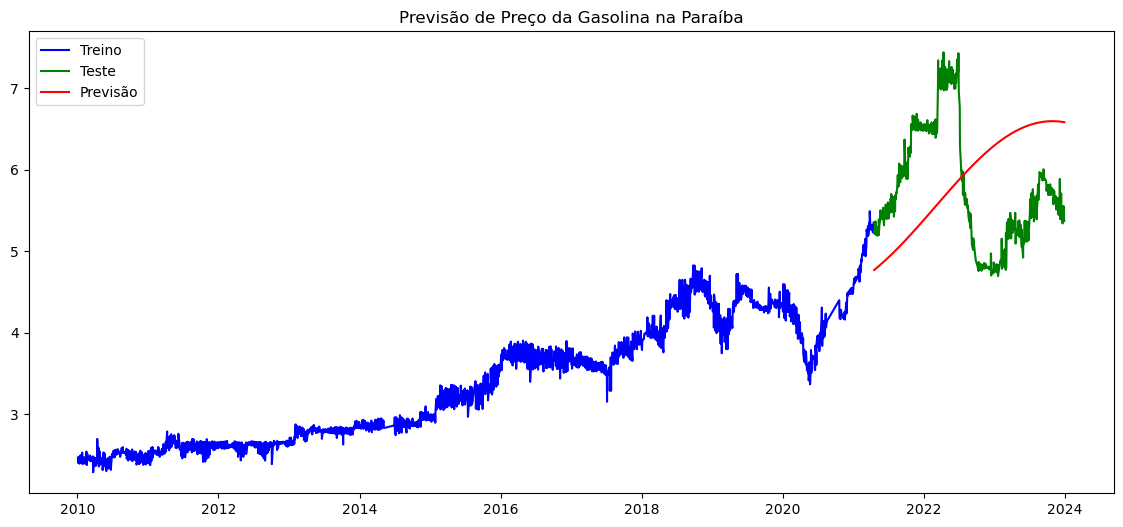

In [ ]:
# Previsão para o conjunto de teste
forecast = model_svr.predict(test.index.to_numpy().reshape(-1, 1))

results_df = test.copy()
results_df['Forecast'] = forecast

# Visualizar o resultado
plt.figure(figsize=(14, 6))

plt.plot(train, label='Treino', color='blue')
plt.plot(test, label='Teste', color='green')
plt.plot(results_df['Forecast'], label='Previsão', color='red')

plt.legend(loc='upper left')
plt.title('Previsão de Preço da Gasolina na Paraíba')
plt.show()

### Avaliando o modelo

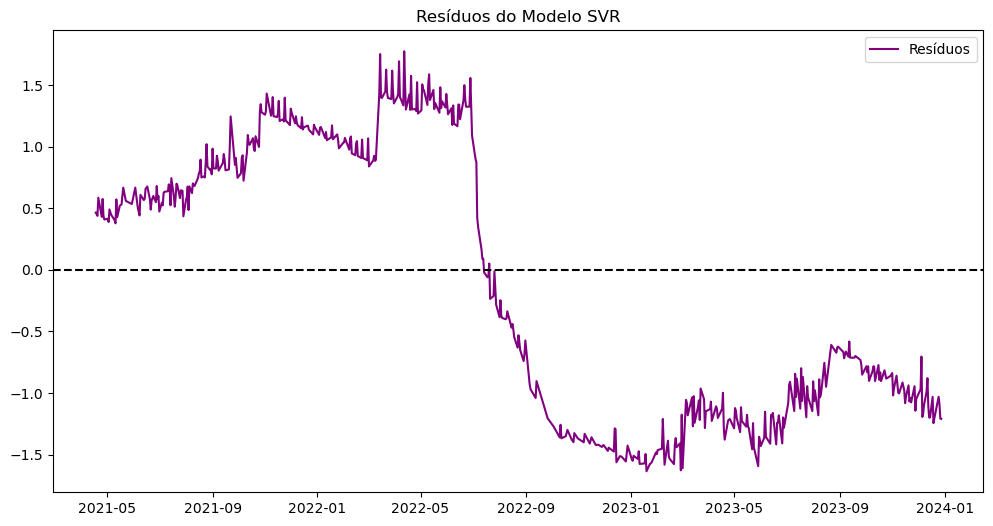

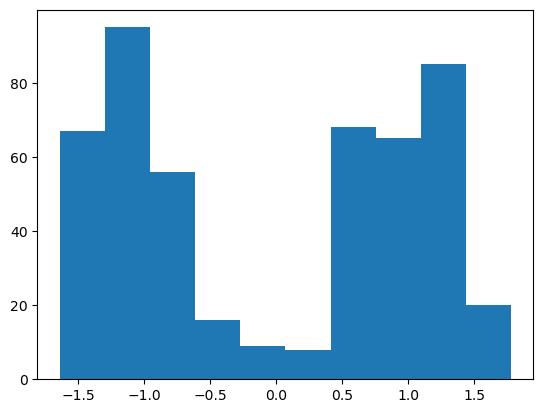

Shapiro-Wilk Test: W=0.8737, p-value=0.0000
Shapiro-Wilk Test: A distribuição dos resíduos difere significativamente de uma distribuição normal.
Jarque-Bera Test: Statistic=56.0726, p-value=0.0000
Jarque-Bera Test: A distribuição dos resíduos difere significativamente de uma distribuição normal.


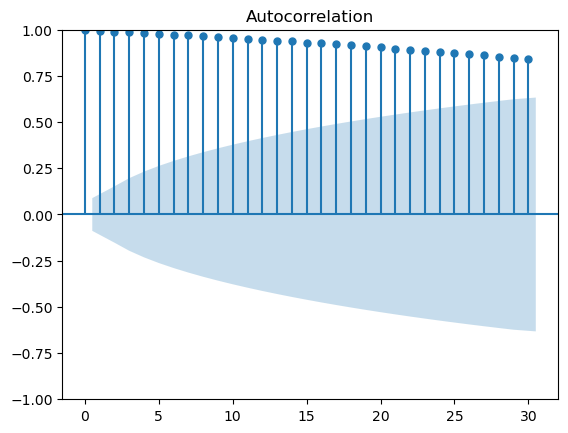

In [ ]:
# avaliar o residuo do modelo
residuals = test["Valor de Venda"] - forecast

# Plotar os resíduos
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Resíduos', color='purple')
plt.axhline(0, linestyle='--', color='black')
plt.legend()
plt.title('Resíduos do Modelo SVR')
plt.show()

# verificar se o residuo tem distribuição normal
plt.hist(residuals)
plt.show()

# Normalidade dos resíduos
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
if shapiro_test.pvalue > 0.05:
    print("Shapiro-Wilk Test: A distribuição dos resíduos não difere significativamente de uma distribuição normal.")
else:
    print("Shapiro-Wilk Test: A distribuição dos resíduos difere significativamente de uma distribuição normal.")

# Normalidade dos resíduos
jarque_bera_test = jarque_bera(residuals)
print(f"Jarque-Bera Test: Statistic={jarque_bera_test.statistic:.4f}, p-value={jarque_bera_test.pvalue:.4f}")
if jarque_bera_test.pvalue > 0.05:
    print("Jarque-Bera Test: A distribuição dos resíduos não difere significativamente de uma distribuição normal.")
else:
    print("Jarque-Bera Test: A distribuição dos resíduos difere significativamente de uma distribuição normal.")

# Plotar ACF dos resíduos
plot_acf(residuals, lags=30)
plt.show()

